# Running Neural GAM - Linear regression

1. Install requirements
2. Load data
3. Train NeuralGAM
4. Visualize partial dependence plots

In [ ]:
%pip install neuralGAM

/bin/bash: /home/iortega/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import pandas as pd

Load dataset into Pandas Dataframes. If you want to preprocess or select some features, do it here. Our synthetic dataset is composed of train and test files, which we load separately.

In [2]:
from neuralGAM.dataset import generate_data

X_train, y_train, fs_train = generate_data(nrows=24500, err_type="homoscedastic", distribution = "uniform", family = "binomial", seed=343142)
# center theoretical fs for plotting
fs_train = fs_train - fs_train.mean()

X_test, y_test, fs_test = generate_data(nrows=5000, err_type="homoscedastic", distribution = "uniform", family = "binomial", seed=343142)
# center theoretical fs for plotting
fs_test = fs_test - fs_test.mean()


y = beta0 + f(x1) + f(x2) + f(x3) =  2 + x1^2 + 2x2 + sin(x3)
y = beta0 + f(x1) + f(x2) + f(x3) =  2 + x1^2 + 2x2 + sin(x3)


Create and Train NeuralGAM instance of Binomial Family. Convert probs in y_train to {1,0} 

In [3]:
y_train

0        0.980726
1        0.488786
2        0.062728
3        0.001250
4        0.008913
           ...   
24495    0.420101
24496    0.071939
24497    0.695262
24498    0.986270
24499    0.948513
Length: 24500, dtype: float64

In [8]:
from neuralGAM.model import NeuralGAM

output_path = "./results"
# Create results directory
if not os.path.exists(output_path):
    os.makedirs(output_path)

units = [1024]
learning_rate = 0.00053

y_train_binomial = np.random.binomial(1, y_train, size=y_train.shape[0])

ngam = NeuralGAM(family="binomial", num_units=units, learning_rate=learning_rate, verbose=1)

muhat, fs_train_estimated, eta = ngam.fit(X_train = X_train, 
                                y_train = y_train_binomial, 
                                max_iter_ls = 10, 
                                bf_threshold=10e-5,
                                ls_threshold=0.1,
                                max_iter_backfitting=10,
                                parallel=True)



Fitting GAM
 -- local scoring iter = 10
 -- backfitting iter = 10
 -- ls_threshold = 0.1
 -- bf_threshold = 0.0001
 -- learning_rate = 0.00053

Using parallel execution
Local Scoring Iteration 1
BACKFITTING ITERATION #1: Current err = 0.0
Dev delta = 0.003106875003117605
Convergence achieved.


/home/iortega/miniconda3/envs/env-pyNeuralGAM/lib/python3.9/site-packages/neuralGAM/model.py:260: RuntimeWarning: divide by zero encountered in log
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),
/home/iortega/miniconda3/envs/env-pyNeuralGAM/lib/python3.9/site-packages/neuralGAM/model.py:260: RuntimeWarning: invalid value encountered in multiply
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),
/home/iortega/miniconda3/envs/env-pyNeuralGAM/lib/python3.9/site-packages/neuralGAM/model.py:260: RuntimeWarning: divide by zero encountered in log
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),
/home/iortega/miniconda3/envs/env-pyNeuralGAM/lib/python3.9/site-packages/neuralGAM/model.py:260: RuntimeWarning: invalid value encountered in multiply
  2 * (y * np.log(y)) + ((1 - y) * np.log(1 - y)),


Once we trained the model, we can visualize the learnt partial effects from the training set. In this case, we will use an auxiliary function that allows us to plot both the original (theretical) functions and the learnt partial effect from the training set

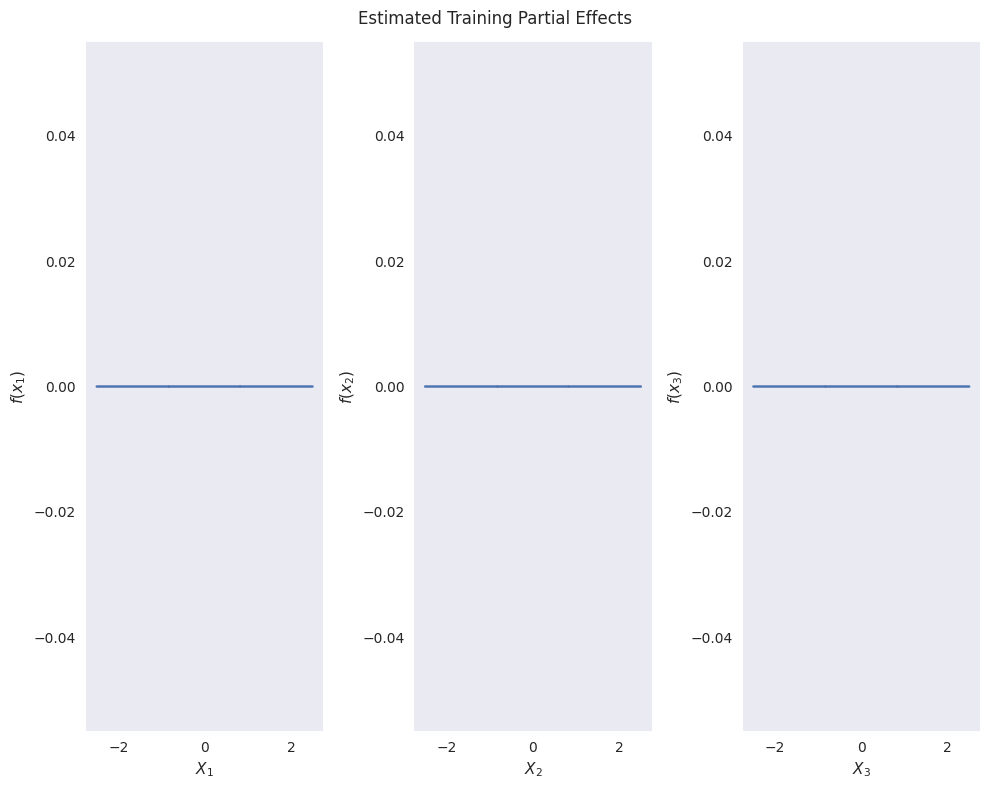

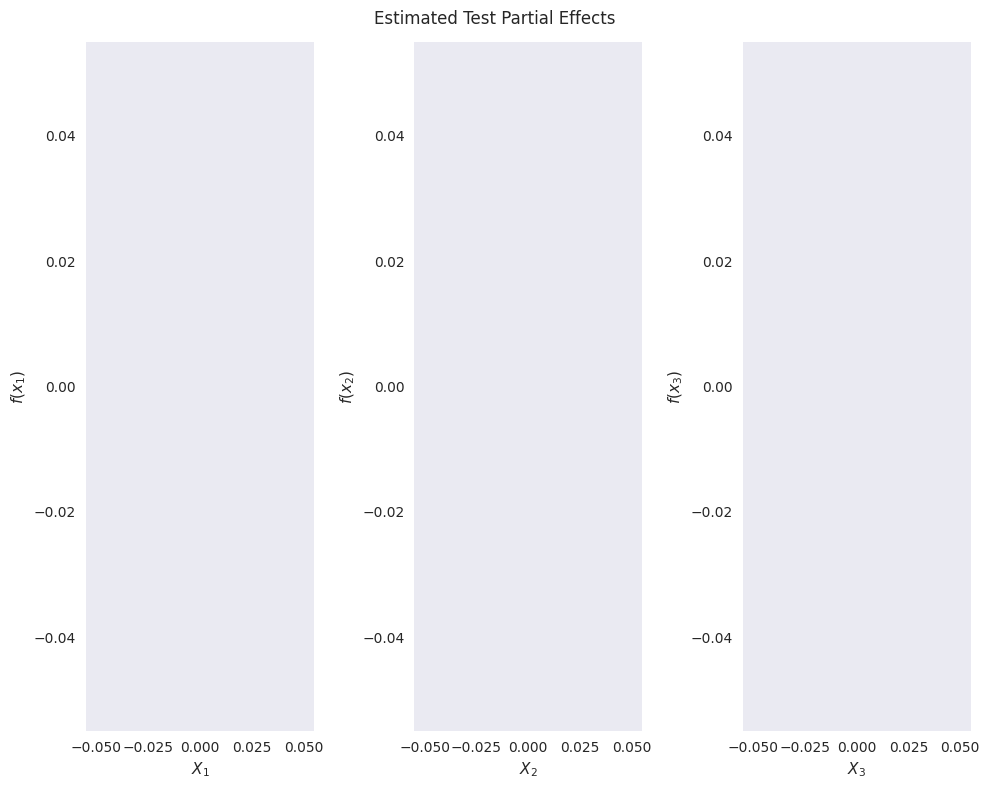

In [5]:
from neuralGAM.plot import plot_partial_dependencies
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plot_partial_dependencies(x=X_train, fs=fs_train_estimated, title="Estimated Training Partial Effects")

fs_test_est = ngam.predict(X_test, type = "terms")
plot_partial_dependencies(x=X_test, fs=fs_test_est, title="Estimated Test Partial Effects")

We can now use the trained NeuralGAM model to make predictions on unseen data, and compute the MSE between the trained and predicted estimations: 

In [6]:
y_pred = ngam.predict(X_test, type = "response")
pred_err = mean_squared_error(y_test, y_pred)
print("MSE in the test set = {0}".format(str(pred_err)))

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method